# Load and prepare image datasets for classification

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
# import tensorflow_datasets as tfds

## Setup

In [2]:
projectPath= os.path.join("D:\\Data\\2023-01 Colosseum")
sessionPath = os.path.join(projectPath,"Research",'IMG_training','Materials')

data_dir= pathlib.Path(sessionPath)

## Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility.

### Create a dataset

Define some parameters for the loader:

In [3]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6252 files belonging to 3 classes.
Using 5002 files for training.


In [47]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6252 files belonging to 3 classes.
Using 1250 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [48]:
class_names = train_ds.class_names
print(class_names)

['0.0', '1.0', '4.0']


### Visualize the data

Here are the first nine images from the training dataset.

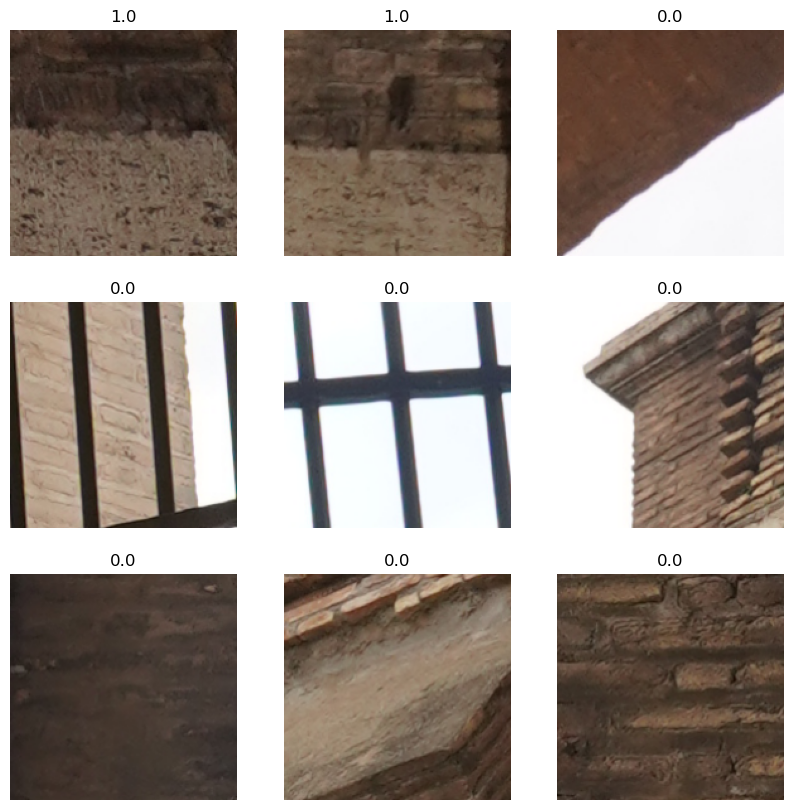

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [50]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [51]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.008779485 0.7428748


Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [52]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [53]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [54]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [55]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
157/157 [==============================] - 98s 622ms/step - loss: 0.6065 - accuracy: 0.7777 - val_loss: 0.5226 - val_accuracy: 0.7808
Epoch 2/3
157/157 [==============================] - 10s 65ms/step - loss: 0.4650 - accuracy: 0.7917 - val_loss: 0.4105 - val_accuracy: 0.8192
Epoch 3/3
157/157 [==============================] - 10s 65ms/step - loss: 0.3971 - accuracy: 0.8227 - val_loss: 0.3891 - val_accuracy: 0.8272


Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) tutorial.

You may notice the validation accuracy is low compared to the training accuracy, indicating your model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Using tf.data for finer control

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/daisy/16291797949_a1b1b7c2bd_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/daisy/5885826924_38fdc6bcaa_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/tulips/430785322_7ddef64c68_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/4878447831_e904c60cf8_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/5970869550_d7d9fabebd_n.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into training and validation sets:

In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

You can print the length of each dataset as follows:

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [25]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [30]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

2022-07-12 01:23:38.007187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


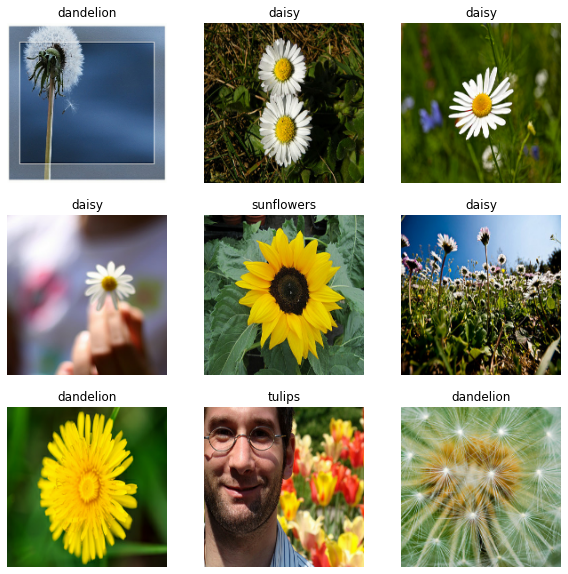

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by `tf.keras.utils.image_dataset_from_directory` above. You can continue training the model with it. As before, you will train for just a few epochs to keep the running time short.

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3



 1/92 [..............................] - ETA: 35s - loss: 0.7523 - accuracy: 0.7500


 5/92 [>.............................] - ETA: 1s - loss: 0.7052 - accuracy: 0.7563 


 9/92 [=>............................] - ETA: 1s - loss: 0.7532 - accuracy: 0.7222


13/92 [===>..........................] - ETA: 1s - loss: 0.7654 - accuracy: 0.7091


17/92 [====>.........................] - ETA: 1s - loss: 0.7270 - accuracy: 0.7353


21/92 [=====>........................] - ETA: 1s - loss: 0.7261 - accuracy: 0.7336


25/92 [=======>......................] - ETA: 1s - loss: 0.7304 - accuracy: 0.7325


29/92 [========>.....................] - ETA: 1s - loss: 0.7384 - accuracy: 0.7188


33/92 [=========>....................] - ETA: 0s - loss: 0.7379 - accuracy: 0.7188


37/92 [===========>..................] - ETA: 0s - loss: 0.7300 - accuracy: 0.7255


41/92 [============>.................] - ETA: 0s - loss: 0.7256 - accuracy: 0.7264


45/92 [=============>................] - ETA: 0s - loss: 0.7246 - accuracy: 0.7257


49/92 [==============>...............] - ETA: 0s - loss: 0.7130 - accuracy: 0.7309


53/92 [================>.............] - ETA: 0s - loss: 0.7067 - accuracy: 0.7300


57/92 [=================>............] - ETA: 0s - loss: 0.7034 - accuracy: 0.7330


61/92 [==================>...........] - ETA: 0s - loss: 0.7031 - accuracy: 0.7321


65/92 [====================>.........] - ETA: 0s - loss: 0.7066 - accuracy: 0.7303


69/92 [=====================>........] - ETA: 0s - loss: 0.7100 - accuracy: 0.7292


73/92 [======================>.......] - ETA: 0s - loss: 0.7048 - accuracy: 0.7324


77/92 [========================>.....] - ETA: 0s - loss: 0.7017 - accuracy: 0.7313


81/92 [=========================>....] - ETA: 0s - loss: 0.6996 - accuracy: 0.7323


85/92 [==========================>...] - ETA: 0s - loss: 0.6951 - accuracy: 0.7331


89/92 [============================>.] - ETA: 0s - loss: 0.6946 - accuracy: 0.7335


92/92 [==============================] - 2s 20ms/step - loss: 0.6971 - accuracy: 0.7326 - val_loss: 0.6731 - val_accuracy: 0.7507


Epoch 2/3



 1/92 [..............................] - ETA: 1s - loss: 0.7189 - accuracy: 0.7500


 5/92 [>.............................] - ETA: 1s - loss: 0.5729 - accuracy: 0.8000


 9/92 [=>............................] - ETA: 1s - loss: 0.5971 - accuracy: 0.7882


13/92 [===>..........................] - ETA: 1s - loss: 0.5577 - accuracy: 0.8101


17/92 [====>.........................] - ETA: 1s - loss: 0.5500 - accuracy: 0.8199


21/92 [=====>........................] - ETA: 1s - loss: 0.5395 - accuracy: 0.8214


25/92 [=======>......................] - ETA: 1s - loss: 0.5274 - accuracy: 0.8200


29/92 [========>.....................] - ETA: 0s - loss: 0.5354 - accuracy: 0.8147


33/92 [=========>....................] - ETA: 0s - loss: 0.5277 - accuracy: 0.8182


37/92 [===========>..................] - ETA: 0s - loss: 0.5199 - accuracy: 0.8209


41/92 [============>.................] - ETA: 0s - loss: 0.5210 - accuracy: 0.8209


45/92 [=============>................] - ETA: 0s - loss: 0.5150 - accuracy: 0.8215


49/92 [==============>...............] - ETA: 0s - loss: 0.5119 - accuracy: 0.8240


53/92 [================>.............] - ETA: 0s - loss: 0.5053 - accuracy: 0.8261


57/92 [=================>............] - ETA: 0s - loss: 0.4964 - accuracy: 0.8300


61/92 [==================>...........] - ETA: 0s - loss: 0.4935 - accuracy: 0.8304


65/92 [====================>.........] - ETA: 0s - loss: 0.4933 - accuracy: 0.8298


69/92 [=====================>........] - ETA: 0s - loss: 0.4911 - accuracy: 0.8297


73/92 [======================>.......] - ETA: 0s - loss: 0.4878 - accuracy: 0.8301


77/92 [========================>.....] - ETA: 0s - loss: 0.4846 - accuracy: 0.8304


81/92 [=========================>....] - ETA: 0s - loss: 0.4872 - accuracy: 0.8291


85/92 [==========================>...] - ETA: 0s - loss: 0.4864 - accuracy: 0.8283


89/92 [============================>.] - ETA: 0s - loss: 0.4890 - accuracy: 0.8265


92/92 [==============================] - 2s 17ms/step - loss: 0.4899 - accuracy: 0.8270 - val_loss: 0.6657 - val_accuracy: 0.7439


Epoch 3/3



 1/92 [..............................] - ETA: 1s - loss: 0.2945 - accuracy: 0.9688


 5/92 [>.............................] - ETA: 1s - loss: 0.2808 - accuracy: 0.9187


 9/92 [=>............................] - ETA: 1s - loss: 0.2586 - accuracy: 0.9236


13/92 [===>..........................] - ETA: 1s - loss: 0.2730 - accuracy: 0.9159


17/92 [====>.........................] - ETA: 1s - loss: 0.3042 - accuracy: 0.9007


21/92 [=====>........................] - ETA: 1s - loss: 0.3072 - accuracy: 0.9077


25/92 [=======>......................] - ETA: 1s - loss: 0.3209 - accuracy: 0.9000


29/92 [========>.....................] - ETA: 0s - loss: 0.3180 - accuracy: 0.9009


33/92 [=========>....................] - ETA: 0s - loss: 0.3190 - accuracy: 0.8987


37/92 [===========>..................] - ETA: 0s - loss: 0.3130 - accuracy: 0.8986


41/92 [============>.................] - ETA: 0s - loss: 0.3083 - accuracy: 0.9017


45/92 [=============>................] - ETA: 0s - loss: 0.3120 - accuracy: 0.8979


49/92 [==============>...............] - ETA: 0s - loss: 0.3083 - accuracy: 0.8986


53/92 [================>.............] - ETA: 0s - loss: 0.3061 - accuracy: 0.9009


57/92 [=================>............] - ETA: 0s - loss: 0.3021 - accuracy: 0.9024


61/92 [==================>...........] - ETA: 0s - loss: 0.3080 - accuracy: 0.9006


65/92 [====================>.........] - ETA: 0s - loss: 0.3016 - accuracy: 0.9029


69/92 [=====================>........] - ETA: 0s - loss: 0.3107 - accuracy: 0.8990


73/92 [======================>.......] - ETA: 0s - loss: 0.3072 - accuracy: 0.9003


77/92 [========================>.....] - ETA: 0s - loss: 0.3119 - accuracy: 0.8981


81/92 [=========================>....] - ETA: 0s - loss: 0.3132 - accuracy: 0.8970


85/92 [==========================>...] - ETA: 0s - loss: 0.3185 - accuracy: 0.8956


89/92 [============================>.] - ETA: 0s - loss: 0.3223 - accuracy: 0.8940


92/92 [==============================] - 2s 17ms/step - loss: 0.3203 - accuracy: 0.8937 - val_loss: 0.7740 - val_accuracy: 0.7275


## Using TensorFlow Datasets

So far, this tutorial has focused on loading data off disk. You can also find a dataset to use by exploring the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) of easy-to-download datasets at [TensorFlow Datasets](https://www.tensorflow.org/datasets).

As you have previously loaded the Flowers dataset off disk, let's now import it with TensorFlow Datasets.

Download the Flowers [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) using TensorFlow Datasets:

In [33]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The flowers dataset has five classes:

In [34]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


 Retrieve an image from the dataset:

2022-07-12 01:23:46.732112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


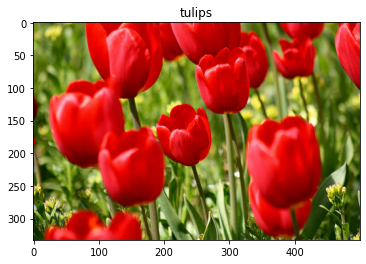

In [35]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

As before, remember to batch, shuffle, and configure the training, validation, and test sets for performance:

In [36]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

You can find a complete example of working with the Flowers dataset and TensorFlow Datasets by visiting the [Data augmentation](../images/data_augmentation.ipynb) tutorial.

## Next steps

This tutorial showed two ways of loading images off disk. First, you learned how to load and preprocess an image dataset using Keras preprocessing layers and utilities. Next, you learned how to write an input pipeline from scratch using `tf.data`. Finally, you learned how to download a dataset from TensorFlow Datasets.

For your next steps:

- You can learn [how to add data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).
- To learn more about `tf.data`, you can visit the [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data) guide.